Change log:
- v24 - instead of limit to each price group, only duplicate the target price group during trianing.
- v23 - build two model for each price group, limit the training set to each target price group

### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

### Params

In [2]:
is_log_target = True
is_per_area_target = True
is_duplicated_train = True

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

#cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_num_add = ['building_per_land_area']
cols_cat_add = ['encoded_latlon']

#cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Processing

In [3]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
    return df

In [4]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()
    
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)
    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)

#        return pd.concat([df, encoded1, encoded2], axis=1)
        return df

In [5]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [6]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [7]:
df = pd.read_csv('dataset/train.csv', dtype=object)

In [8]:
df_group = pd.read_csv('output/metamodel-03-lgb-binary-cv.csv')  # add price group
df = df.merge(df_group, how='left', on='building_id')
assert not df['price_group_pred'].isnull().any()
df.check()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price,price_group,price_group_pred
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775,0,0
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,115,1,15872,1,32221,1,40.07357348973039,3321452.0,1,1
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373,1,1
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045,1,1
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696,0,0
59995,Oh5Hwr9LrWApC2mr,1,5,19040,2,4,2,9193,2,NaN,...,53,1,1435,1,4611,1,145.27967019169262,987021.4150420949,0,0
59996,PiOgZqfsDVlTq1zs,8,13,19706,14,2,5,17168,0,3.738411744735565,...,316,1,5659,1,22826,1,18.81499793345573,15725223.997450478,1,1
59997,FQmlgGohzzWuKUzu,8,7,19901,11,0,2,13729,0,NaN,...,348,1,13252,1,32687,1,94.79959334423607,11815402.03862225,1,1
59998,zjzfMwXhDswdEaI2,8,13,19975,5,1,2,7063,2,NaN,...,142,1,5317,1,21087,1,33.10458025153816,18084995.81999832,1,1
59999,iN4H6wBMtvJpF0SN,8,7,20385,5,1,2,8310,2,NaN,...,249,1,15417,1,32826,1,47.50987600102272,8510295.87633061,1,1


shape = (60000, 237)


In [9]:
price_groups = sorted(df['price_group_pred'].unique())
print('Price groups:', 'N =', len(price_groups), price_groups)

Price groups: N = 2 [0, 1]


In [10]:
print('Binary classification accuracy:', '%.5f'%(df['price_group'] == df['price_group_pred']).mean())

Binary classification accuracy: 0.95893


### Preprocessing

In [11]:
df = pre_processing(df, cols_num, cols_cat)

/home/skyhuang/.local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [12]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

In [13]:
# PARS #
N_feats_rm = 68
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],
                         'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

print('N feats (before):', len(cols_feats))
cols_feats = list(set(cols_feats) - set(feats_rm))
print('N feats (after):', len(cols_feats))
print(cols_feats)

[[0 'divorce_rate' 5709.20035 3.333296666667593]
 [1 'I_250' 5709.200316666666 3.333263333333889]
 [2 'XI_100' 5708.200346666667 2.33329333333495]
 [3 'VI_index_500' 5707.867050000001 1.9999966666682667]
 [4 'IX_index_50' 5707.86704 1.9999866666676098]
 [5 'VI_500' 5707.866983333333 1.9999300000008589]
 [6 'XIV_10' 5707.533710000001 1.666656666668132]
 [7 'XI_index_500' 5707.200386666666 1.3333333333339397]
 [8 'VI_index_1000' 5707.200383333334 1.3333300000012969]
 [9 'V_100' 5707.200373333333 1.33332000000064]
 [10 'VII_10' 5707.200363333334 1.333310000001802]
 [11 'X_100' 5707.200336666666 1.3332833333333838]
 [12 'XII_index_50' 5706.867056666667 1.0000033333344618]
 [15 'X_index_500' 5706.867050000001 0.9999966666682667]
 [14 'X_10' 5706.867050000001 0.9999966666682667]
 [13 'II_10' 5706.867050000001 0.9999966666682667]
 [16 'II_index_500' 5706.867046666666 0.9999933333338049]
 [17 'V_index_1000' 5706.867046666666 0.9999933333338049]
 [18 'XIII_10' 5706.867043333335 0.99999000000207

### Grid search

In [14]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.01,
             }

lgb_other_params = {'num_boost_round': 50000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                    'keep_training_booster': True,
                   }

# prvs baseline best estimator
# ('objective', 'mse'), ('metric', 'mape'),
# ('learning_rate', 0.015), ('num_leaves', 255),
# ('feature_fraction', 0.5), ('min_data_in_leaf', 5),
# ('lambda_l1', 0.1), ('lambda_l2', 0.1)),
# 5524.863045737181,
# [5528.862755759428, 5530.862894274216, 5514.863487177898]]

#params_gsearch = {'max_depth':[-1, 8],
#                  'num_leaves': [200, 255]}

#### Round 1

In [15]:
params_gsearch = {'max_depth': [-1, 8, 16, 24, 28, 32],
                  'num_leaves': [127, 255, 275, 280, 300, 319],
                  'feature_fraction': [0.3, 0.4, 0.5, 0.6, 0.7],
                  'min_data_in_leaf': list(range(2, 20, 2)),
                  'lambda_l1': [0.0, 0.01, 0.05, 0.1],
                  'lambda_l2': [0.0, 0.01, 0.05, 0.1],
                  'max_bin': [255, 383, 511, 1023],
                  'min_sum_hessian_in_leaf': [0.1, 0.01, 0.001, 0.0001],
                  'min_data_per_group': [100, 75, 50, 25, 10, 5],
                 }


N_fold = 3
N_iter = 40
score_low_bound = 5300 # if score smaller than this, skip the param set

In [16]:
# Round 1
rand_params_set = [{
    'max_depth': 24,
    'num_leaves': 300,
    'feature_fraction': 0.5,
    'min_data_in_leaf': 10,
    'lambda_l1': 0.1,
    'lambda_l2': 0.0,
    'max_bin': 255,
    'min_sum_hessian_in_leaf': 0.001,
    'min_data_per_group': 100,
}]
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)
gsearch = {}

In [17]:
rand_params_set

[{'max_depth': 24,
  'num_leaves': 300,
  'feature_fraction': 0.5,
  'min_data_in_leaf': 10,
  'lambda_l1': 0.1,
  'lambda_l2': 0.0,
  'max_bin': 255,
  'min_sum_hessian_in_leaf': 0.001,
  'min_data_per_group': 100},
 {'max_depth': -1,
  'num_leaves': 127,
  'feature_fraction': 0.3,
  'min_data_in_leaf': 12,
  'lambda_l1': 0.0,
  'lambda_l2': 0.0,
  'max_bin': 383,
  'min_sum_hessian_in_leaf': 0.1,
  'min_data_per_group': 100},
 {'max_depth': 8,
  'num_leaves': 319,
  'feature_fraction': 0.6,
  'min_data_in_leaf': 16,
  'lambda_l1': 0.1,
  'lambda_l2': 0.0,
  'max_bin': 255,
  'min_sum_hessian_in_leaf': 0.0001,
  'min_data_per_group': 10},
 {'max_depth': 28,
  'num_leaves': 255,
  'feature_fraction': 0.5,
  'min_data_in_leaf': 6,
  'lambda_l1': 0.05,
  'lambda_l2': 0.1,
  'max_bin': 383,
  'min_sum_hessian_in_leaf': 0.0001,
  'min_data_per_group': 5},
 {'max_depth': 28,
  'num_leaves': 319,
  'feature_fraction': 0.3,
  'min_data_in_leaf': 16,
  'lambda_l1': 0.01,
  'lambda_l2': 0.0,
  

In [18]:
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    print('train:', [(df_train['price_group_pred']==gp).sum() for gp in price_groups], 
          'val:', [(df_val['price_group_pred']==gp).sum() for gp in price_groups])

train: [19292, 20708] val: [9665, 10335]
train: [19238, 20762] val: [9719, 10281]
train: [19384, 20616] val: [9573, 10427]


In [19]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)
    
    # split prices group
    lgb_trains = []; lgb_vals = []
    for pg in price_groups:
        df_train_g = df_train.loc[df_train['price_group_pred'] == pg]
        df_val_g = df_val.loc[df_val['price_group_pred'] == pg]
        
        if is_duplicated_train:
            df_train_g = pd.concat([df_train_g, df_train], ignore_index=True)
            #df_val_g = pd.concat([df_val_g, df_val], ignore_index=True)

        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train_g[cols_feats], df_train_g[col_target]).construct()
        lgb_val = lgb.Dataset(df_val_g[cols_feats], df_val_g[col_target], reference=lgb_train).construct()
        lgb_trains.append(lgb_train)
        lgb_vals.append(lgb_val)
        
    # random sample - grid search
    rand_params_next = []
    for params_rand in rand_params_set:
        tp0 = time.time()
        params = params_fix.copy()
        params.update( params_rand )

        #models = []
        best_iters = []
        for pg, lgb_train, lgb_val in zip(price_groups, lgb_trains, lgb_vals):
            model = lgb.train(params, lgb_train, valid_sets=lgb_val, 
                              **lgb_other_params)
            #models.append(model)
            val_gp_mask = df_val['price_group_pred'] == pg
            df_val.loc[val_gp_mask, col_target+'_pred'] = (
                model.predict(df_val.loc[val_gp_mask, cols_feats])
            )
            best_iters.append(model.best_iteration)
        
        mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
        mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
        mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
        
        y_pred_final = post_processing(df_val[col_target+'_pred'], df_val)
        score = cal_score(df_val['total_price'], y_pred_final)

        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (score, mse, mae, mape),
              'iters:', best_iters,
              ' - Time spent:', time.time() - tp0)
        print()
        if score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(best_iters)
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
t1 = time.time()
# aggregate, sort gsearch results
# [0. params, 1. mean score, 2. mean mse, 3. mean mae, 4. mean mape, 5. iters, 
#  6. scores list, 7. mse list, 8. mae list, 9. mape list]
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)

==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0118036
[4000]	valid_0's mape: 0.011673
[6000]	valid_0's mape: 0.0116361
[8000]	valid_0's mape: 0.0116227
[10000]	valid_0's mape: 0.0116168
[12000]	valid_0's mape: 0.0116137
[14000]	valid_0's mape: 0.0116124
[16000]	valid_0's mape: 0.0116119
Early stopping, best iteration is:
[15315]	valid_0's mape: 0.0116119
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00781297
[4000]	valid_0's mape: 0.00769021
[6000]	valid_0's mape: 0.00765677
[8000]	valid_0's mape: 0.0076442
[10000]	valid_0's mape: 0.00763806
[12000]	valid_0's mape: 0.00763504
[14000]	valid_0's mape: 0.00763318
[16000]	valid_0's mape: 0.00763282
Early stopping, best iteration is:
[15046]	valid_0's mape: 0.00763281
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 300, 'feature_fraction': 0.5, '

[2000]	valid_0's mape: 0.0121009
[4000]	valid_0's mape: 0.0117828
[6000]	valid_0's mape: 0.0116672
[8000]	valid_0's mape: 0.0116099
[10000]	valid_0's mape: 0.0115788
[12000]	valid_0's mape: 0.0115627
[14000]	valid_0's mape: 0.0115521
[16000]	valid_0's mape: 0.0115468
[18000]	valid_0's mape: 0.0115413
[20000]	valid_0's mape: 0.011538
[22000]	valid_0's mape: 0.0115348
[24000]	valid_0's mape: 0.0115327
[26000]	valid_0's mape: 0.011531
[28000]	valid_0's mape: 0.01153
[30000]	valid_0's mape: 0.0115293
[32000]	valid_0's mape: 0.0115288
[34000]	valid_0's mape: 0.0115283
[36000]	valid_0's mape: 0.0115281
Early stopping, best iteration is:
[36285]	valid_0's mape: 0.011528
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00810641
[4000]	valid_0's mape: 0.0078198
[6000]	valid_0's mape: 0.00771499
[8000]	valid_0's mape: 0.00766837
[10000]	valid_0's mape: 0.0076459
[12000]	valid_0's mape: 0.0076308
[14000]	valid_0's mape: 0.00762248
[16000]	valid_0's mape: 0.

[2000]	valid_0's mape: 0.011805
[4000]	valid_0's mape: 0.0116723
[6000]	valid_0's mape: 0.0116394
[8000]	valid_0's mape: 0.0116274
[10000]	valid_0's mape: 0.0116221
[12000]	valid_0's mape: 0.0116194
[14000]	valid_0's mape: 0.0116179
[16000]	valid_0's mape: 0.0116169
[18000]	valid_0's mape: 0.0116162
[20000]	valid_0's mape: 0.0116159
[22000]	valid_0's mape: 0.0116156
[24000]	valid_0's mape: 0.0116154
[26000]	valid_0's mape: 0.0116153
[28000]	valid_0's mape: 0.0116152
[30000]	valid_0's mape: 0.0116151
[32000]	valid_0's mape: 0.0116151
[34000]	valid_0's mape: 0.0116151
[36000]	valid_0's mape: 0.011615
[38000]	valid_0's mape: 0.011615
[40000]	valid_0's mape: 0.011615
[42000]	valid_0's mape: 0.011615
[44000]	valid_0's mape: 0.011615
[46000]	valid_0's mape: 0.011615
[48000]	valid_0's mape: 0.011615
[50000]	valid_0's mape: 0.011615
Did not meet early stopping. Best iteration is:
[49836]	valid_0's mape: 0.011615
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's m

[26000]	valid_0's mape: 0.0117979
[28000]	valid_0's mape: 0.0117967
[30000]	valid_0's mape: 0.0117958
[32000]	valid_0's mape: 0.0117951
[34000]	valid_0's mape: 0.0117947
[36000]	valid_0's mape: 0.0117943
[38000]	valid_0's mape: 0.011794
[40000]	valid_0's mape: 0.0117938
[42000]	valid_0's mape: 0.0117937
[44000]	valid_0's mape: 0.0117935
[46000]	valid_0's mape: 0.0117935
[48000]	valid_0's mape: 0.0117934
[50000]	valid_0's mape: 0.0117934
Did not meet early stopping. Best iteration is:
[49999]	valid_0's mape: 0.0117934
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00816164
[4000]	valid_0's mape: 0.00792368
[6000]	valid_0's mape: 0.00783065
[8000]	valid_0's mape: 0.00778427
[10000]	valid_0's mape: 0.00775829
[12000]	valid_0's mape: 0.00774454
[14000]	valid_0's mape: 0.0077335
[16000]	valid_0's mape: 0.00772685
[18000]	valid_0's mape: 0.00772232
[20000]	valid_0's mape: 0.00771873
[22000]	valid_0's mape: 0.00771621
[24000]	valid_0's mape: 0.0077142

[22000]	valid_0's mape: 0.00766572
[24000]	valid_0's mape: 0.00766256
[26000]	valid_0's mape: 0.00765987
[28000]	valid_0's mape: 0.00765826
[30000]	valid_0's mape: 0.00765707
[32000]	valid_0's mape: 0.00765581
[34000]	valid_0's mape: 0.00765476
[36000]	valid_0's mape: 0.00765404
[38000]	valid_0's mape: 0.00765323
[40000]	valid_0's mape: 0.00765261
[42000]	valid_0's mape: 0.0076519
[44000]	valid_0's mape: 0.00765158
[46000]	valid_0's mape: 0.00765117
[48000]	valid_0's mape: 0.00765075
[50000]	valid_0's mape: 0.0076505
Did not meet early stopping. Best iteration is:
[49965]	valid_0's mape: 0.00765049
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 127, 'feature_fraction': 0.6, 'min_data_in_leaf': 2, 'lambda_l1': 0.0, 'lambda_l2': 0.1, 'max_bin': 1023, 'min_sum_hessian_in_leaf': 0.1, 'min_data_per_group': 5}
score, mse, mae, mape: 5634.86685, 0.03939, 0.12771, 0.00960. iters: [49775, 49965]  - Ti

[2000]	valid_0's mape: 0.0118756
[4000]	valid_0's mape: 0.0117232
[6000]	valid_0's mape: 0.0116788
[8000]	valid_0's mape: 0.0116614
[10000]	valid_0's mape: 0.0116543
[12000]	valid_0's mape: 0.011651
[14000]	valid_0's mape: 0.0116494
[16000]	valid_0's mape: 0.0116483
[18000]	valid_0's mape: 0.0116477
[20000]	valid_0's mape: 0.0116473
[22000]	valid_0's mape: 0.011647
[24000]	valid_0's mape: 0.0116469
[26000]	valid_0's mape: 0.0116468
Early stopping, best iteration is:
[26790]	valid_0's mape: 0.0116467
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00787924
[4000]	valid_0's mape: 0.00773474
[6000]	valid_0's mape: 0.00768987
[8000]	valid_0's mape: 0.00767151
[10000]	valid_0's mape: 0.00766274
[12000]	valid_0's mape: 0.00765833
[14000]	valid_0's mape: 0.0076558
[16000]	valid_0's mape: 0.00765448
[18000]	valid_0's mape: 0.00765362
[20000]	valid_0's mape: 0.00765296
[22000]	valid_0's mape: 0.00765249
[24000]	valid_0's mape: 0.00765219
[26000]	valid_0'

[16000]	valid_0's mape: 0.0076481
[18000]	valid_0's mape: 0.00764742
[20000]	valid_0's mape: 0.007647
[22000]	valid_0's mape: 0.00764676
[24000]	valid_0's mape: 0.00764661
[26000]	valid_0's mape: 0.00764649
[28000]	valid_0's mape: 0.00764642
[30000]	valid_0's mape: 0.00764637
[32000]	valid_0's mape: 0.00764633
[34000]	valid_0's mape: 0.00764632
[36000]	valid_0's mape: 0.0076463
[38000]	valid_0's mape: 0.00764629
[40000]	valid_0's mape: 0.00764629
[42000]	valid_0's mape: 0.00764628
[44000]	valid_0's mape: 0.00764628
[46000]	valid_0's mape: 0.00764628
[48000]	valid_0's mape: 0.00764628
[50000]	valid_0's mape: 0.00764628
Did not meet early stopping. Best iteration is:
[50000]	valid_0's mape: 0.00764628
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 300, 'feature_fraction': 0.6, 'min_data_in_leaf': 2, 'lambda_l1': 0.0, 'lambda_l2': 0.01, 'max_bin': 383, 'min_sum_hessian_in_leaf': 0.01, 'min_data

[2000]	valid_0's mape: 0.011834
[4000]	valid_0's mape: 0.0116889
[6000]	valid_0's mape: 0.0116442
[8000]	valid_0's mape: 0.0116275
[10000]	valid_0's mape: 0.0116198
[12000]	valid_0's mape: 0.0116154
[14000]	valid_0's mape: 0.0116127
[16000]	valid_0's mape: 0.0116113
[18000]	valid_0's mape: 0.0116104
[20000]	valid_0's mape: 0.0116096
[22000]	valid_0's mape: 0.0116092
[24000]	valid_0's mape: 0.0116091
[26000]	valid_0's mape: 0.0116088
[28000]	valid_0's mape: 0.0116086
[30000]	valid_0's mape: 0.0116085
[32000]	valid_0's mape: 0.0116084
Early stopping, best iteration is:
[32546]	valid_0's mape: 0.0116084
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00785114
[4000]	valid_0's mape: 0.00770538
[6000]	valid_0's mape: 0.00766523
[8000]	valid_0's mape: 0.00765271
[10000]	valid_0's mape: 0.00764652
[12000]	valid_0's mape: 0.00764306
[14000]	valid_0's mape: 0.00764158
[16000]	valid_0's mape: 0.00764042
[18000]	valid_0's mape: 0.00763952
[20000]	valid_0's

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00786261
[4000]	valid_0's mape: 0.00773655
[6000]	valid_0's mape: 0.00770774
[8000]	valid_0's mape: 0.00769795
[10000]	valid_0's mape: 0.00769266
[12000]	valid_0's mape: 0.00769029
[14000]	valid_0's mape: 0.00768909
[16000]	valid_0's mape: 0.00768813
[18000]	valid_0's mape: 0.00768774
[20000]	valid_0's mape: 0.00768752
[22000]	valid_0's mape: 0.00768733
[24000]	valid_0's mape: 0.00768716
[26000]	valid_0's mape: 0.00768703
[28000]	valid_0's mape: 0.00768697
[30000]	valid_0's mape: 0.00768689
[32000]	valid_0's mape: 0.00768683
[34000]	valid_0's mape: 0.00768678
[36000]	valid_0's mape: 0.00768675
[38000]	valid_0's mape: 0.00768672
[40000]	valid_0's mape: 0.0076867
[42000]	valid_0's mape: 0.00768668
[44000]	valid_0's mape: 0.00768667
[46000]	valid_0's mape: 0.00768666
[48000]	valid_0's mape: 0.00768665
[50000]	valid_0's mape: 0.00768665
Did not meet early stopping. Best iteration is:
[49999]	valid_0's 

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0116929
[4000]	valid_0's mape: 0.0115497
[6000]	valid_0's mape: 0.0115084
[8000]	valid_0's mape: 0.011491
[10000]	valid_0's mape: 0.0114838
[12000]	valid_0's mape: 0.0114799
[14000]	valid_0's mape: 0.0114781
[16000]	valid_0's mape: 0.0114776
Early stopping, best iteration is:
[15220]	valid_0's mape: 0.0114776
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00794513
[4000]	valid_0's mape: 0.00784534
[6000]	valid_0's mape: 0.0078187
[8000]	valid_0's mape: 0.00780616
[10000]	valid_0's mape: 0.00780107
[12000]	valid_0's mape: 0.00779817
[14000]	valid_0's mape: 0.00779672
[16000]	valid_0's mape: 0.00779605
Early stopping, best iteration is:
[15503]	valid_0's mape: 0.00779605
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 300, 'feature_fraction': 0.5, 'min_data_in_leaf'

[16000]	valid_0's mape: 0.00774564
[18000]	valid_0's mape: 0.00774488
[20000]	valid_0's mape: 0.00774444
[22000]	valid_0's mape: 0.00774421
[24000]	valid_0's mape: 0.00774395
[26000]	valid_0's mape: 0.00774376
[28000]	valid_0's mape: 0.00774358
[30000]	valid_0's mape: 0.00774346
[32000]	valid_0's mape: 0.00774335
[34000]	valid_0's mape: 0.00774329
[36000]	valid_0's mape: 0.00774325
[38000]	valid_0's mape: 0.00774322
Early stopping, best iteration is:
[37348]	valid_0's mape: 0.00774322
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 28, 'num_leaves': 319, 'feature_fraction': 0.3, 'min_data_in_leaf': 16, 'lambda_l1': 0.01, 'lambda_l2': 0.0, 'max_bin': 511, 'min_sum_hessian_in_leaf': 0.01, 'min_data_per_group': 10}
score, mse, mae, mape: 5718.86902, 0.04141, 0.12772, 0.00958. iters: [35561, 37348]  - Time spent: 2047.407666683197

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's ma

[12000]	valid_0's mape: 0.0114678
[14000]	valid_0's mape: 0.0114643
[16000]	valid_0's mape: 0.0114622
[18000]	valid_0's mape: 0.0114611
[20000]	valid_0's mape: 0.0114605
[22000]	valid_0's mape: 0.01146
[24000]	valid_0's mape: 0.0114596
[26000]	valid_0's mape: 0.0114593
[28000]	valid_0's mape: 0.0114592
[30000]	valid_0's mape: 0.0114591
[32000]	valid_0's mape: 0.011459
Early stopping, best iteration is:
[31668]	valid_0's mape: 0.011459
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00794313
[4000]	valid_0's mape: 0.00780757
[6000]	valid_0's mape: 0.00776954
[8000]	valid_0's mape: 0.00775241
[10000]	valid_0's mape: 0.00774279
[12000]	valid_0's mape: 0.00773775
[14000]	valid_0's mape: 0.00773447
[16000]	valid_0's mape: 0.00773287
[18000]	valid_0's mape: 0.00773158
[20000]	valid_0's mape: 0.00773081
[22000]	valid_0's mape: 0.00773027
[24000]	valid_0's mape: 0.00772987
[26000]	valid_0's mape: 0.00772956
[28000]	valid_0's mape: 0.00772933
[30000]	val

[48000]	valid_0's mape: 0.0115711
[50000]	valid_0's mape: 0.0115711
Did not meet early stopping. Best iteration is:
[49855]	valid_0's mape: 0.0115711
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0080091
[4000]	valid_0's mape: 0.00790717
[6000]	valid_0's mape: 0.00788096
[8000]	valid_0's mape: 0.00787069
[10000]	valid_0's mape: 0.0078659
[12000]	valid_0's mape: 0.00786247
[14000]	valid_0's mape: 0.007861
[16000]	valid_0's mape: 0.00786009
[18000]	valid_0's mape: 0.00785939
[20000]	valid_0's mape: 0.00785892
[22000]	valid_0's mape: 0.00785869
[24000]	valid_0's mape: 0.00785849
[26000]	valid_0's mape: 0.00785834
[28000]	valid_0's mape: 0.00785825
[30000]	valid_0's mape: 0.00785818
[32000]	valid_0's mape: 0.00785814
[34000]	valid_0's mape: 0.0078581
[36000]	valid_0's mape: 0.00785806
[38000]	valid_0's mape: 0.00785804
[40000]	valid_0's mape: 0.00785802
[42000]	valid_0's mape: 0.007858
[44000]	valid_0's mape: 0.00785799
[46000]	valid_0's mape: 0.0

[18000]	valid_0's mape: 0.00778717
[20000]	valid_0's mape: 0.00778674
[22000]	valid_0's mape: 0.00778639
[24000]	valid_0's mape: 0.00778617
[26000]	valid_0's mape: 0.00778604
Early stopping, best iteration is:
[25698]	valid_0's mape: 0.00778604
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 300, 'feature_fraction': 0.5, 'min_data_in_leaf': 6, 'lambda_l1': 0.01, 'lambda_l2': 0.01, 'max_bin': 1023, 'min_sum_hessian_in_leaf': 0.001, 'min_data_per_group': 5}
score, mse, mae, mape: 5690.86933, 0.04096, 0.12763, 0.00957. iters: [25776, 25698]  - Time spent: 1839.953899383545

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0122855
[4000]	valid_0's mape: 0.0118794
[6000]	valid_0's mape: 0.0117258
[8000]	valid_0's mape: 0.0116607
[10000]	valid_0's mape: 0.0116261
[12000]	valid_0's mape: 0.0116004
[14000]	valid_0's mape: 0.0115821
[16000]	valid_0's mape: 0.011

[30000]	valid_0's mape: 0.00791207
[32000]	valid_0's mape: 0.00791137
[34000]	valid_0's mape: 0.0079105
[36000]	valid_0's mape: 0.00790964
[38000]	valid_0's mape: 0.00790883
[40000]	valid_0's mape: 0.00790821
[42000]	valid_0's mape: 0.00790752
[44000]	valid_0's mape: 0.00790701
[46000]	valid_0's mape: 0.00790659
[48000]	valid_0's mape: 0.00790628
[50000]	valid_0's mape: 0.0079061
Did not meet early stopping. Best iteration is:
[49992]	valid_0's mape: 0.0079061
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 319, 'feature_fraction': 0.7, 'min_data_in_leaf': 10, 'lambda_l1': 0.01, 'lambda_l2': 0.0, 'max_bin': 511, 'min_sum_hessian_in_leaf': 0.01, 'min_data_per_group': 5}
score, mse, mae, mape: 5622.86736, 0.04142, 0.12953, 0.00971. iters: [26111, 49992]  - Time spent: 1519.5091195106506

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0117771
[4000]	valid

[12000]	valid_0's mape: 0.011576
[14000]	valid_0's mape: 0.011575
Early stopping, best iteration is:
[13730]	valid_0's mape: 0.011575
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00799964
[4000]	valid_0's mape: 0.00790528
[6000]	valid_0's mape: 0.00787703
[8000]	valid_0's mape: 0.00786577
[10000]	valid_0's mape: 0.00786097
[12000]	valid_0's mape: 0.00785834
[14000]	valid_0's mape: 0.00785731
Early stopping, best iteration is:
[14231]	valid_0's mape: 0.00785723
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 319, 'feature_fraction': 0.7, 'min_data_in_leaf': 12, 'lambda_l1': 0.1, 'lambda_l2': 0.0, 'max_bin': 383, 'min_sum_hessian_in_leaf': 0.1, 'min_data_per_group': 100}
score, mse, mae, mape: 5666.86820, 0.04134, 0.12872, 0.00965. iters: [13730, 14231]  - Time spent: 1287.2578053474426

Training until validation scores don't improve for 1000 rounds.


[12000]	valid_0's mape: 0.00782451
[14000]	valid_0's mape: 0.00782275
[16000]	valid_0's mape: 0.00782139
[18000]	valid_0's mape: 0.00782072
[20000]	valid_0's mape: 0.00782029
[22000]	valid_0's mape: 0.00781996
[24000]	valid_0's mape: 0.00781976
[26000]	valid_0's mape: 0.0078196
[28000]	valid_0's mape: 0.00781951
[30000]	valid_0's mape: 0.00781944
[32000]	valid_0's mape: 0.00781939
[34000]	valid_0's mape: 0.00781935
[36000]	valid_0's mape: 0.00781932
[38000]	valid_0's mape: 0.0078193
[40000]	valid_0's mape: 0.00781928
[42000]	valid_0's mape: 0.00781927
[44000]	valid_0's mape: 0.00781926
[46000]	valid_0's mape: 0.00781925
[48000]	valid_0's mape: 0.00781925
[50000]	valid_0's mape: 0.00781925
Did not meet early stopping. Best iteration is:
[49963]	valid_0's mape: 0.00781925
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 280, 'feature_fraction': 0.6, 'min_data_in_leaf': 8, 'lambda_l1': 0.0, 'lamb

[10000]	valid_0's mape: 0.011488
[12000]	valid_0's mape: 0.0114703
[14000]	valid_0's mape: 0.0114603
[16000]	valid_0's mape: 0.0114539
[18000]	valid_0's mape: 0.0114492
[20000]	valid_0's mape: 0.0114463
[22000]	valid_0's mape: 0.0114441
[24000]	valid_0's mape: 0.011442
[26000]	valid_0's mape: 0.0114406
[28000]	valid_0's mape: 0.0114395
[30000]	valid_0's mape: 0.0114387
[32000]	valid_0's mape: 0.011438
[34000]	valid_0's mape: 0.0114376
[36000]	valid_0's mape: 0.0114373
Early stopping, best iteration is:
[35837]	valid_0's mape: 0.0114373
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00816293
[4000]	valid_0's mape: 0.00792584
[6000]	valid_0's mape: 0.00783934
[8000]	valid_0's mape: 0.00779952
[10000]	valid_0's mape: 0.00777488
[12000]	valid_0's mape: 0.00776
[14000]	valid_0's mape: 0.00775101
[16000]	valid_0's mape: 0.00774332
[18000]	valid_0's mape: 0.00773914
[20000]	valid_0's mape: 0.00773562
[22000]	valid_0's mape: 0.00773321
[24000]	valid_0'

[2000]	valid_0's mape: 0.00791007
[4000]	valid_0's mape: 0.00780542
[6000]	valid_0's mape: 0.0077739
[8000]	valid_0's mape: 0.00776055
[10000]	valid_0's mape: 0.00775422
[12000]	valid_0's mape: 0.00775066
[14000]	valid_0's mape: 0.00774851
[16000]	valid_0's mape: 0.00774712
[18000]	valid_0's mape: 0.00774635
Early stopping, best iteration is:
[18682]	valid_0's mape: 0.00774618
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': -1, 'num_leaves': 319, 'feature_fraction': 0.4, 'min_data_in_leaf': 2, 'lambda_l1': 0.05, 'lambda_l2': 0.1, 'max_bin': 1023, 'min_sum_hessian_in_leaf': 0.001, 'min_data_per_group': 100}
score, mse, mae, mape: 5716.86970, 0.04119, 0.12726, 0.00954. iters: [18617, 18682]  - Time spent: 1358.3008012771606

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0119884
[4000]	valid_0's mape: 0.0116727
[6000]	valid_0's mape: 0.0115544
[8000]	valid_0's mape: 0.01

[38000]	valid_0's mape: 0.00777373
[40000]	valid_0's mape: 0.00777345
Early stopping, best iteration is:
[40002]	valid_0's mape: 0.00777345
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 319, 'feature_fraction': 0.6, 'min_data_in_leaf': 16, 'lambda_l1': 0.1, 'lambda_l2': 0.0, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.0001, 'min_data_per_group': 10}
score, mse, mae, mape: 5614.86491, 0.04082, 0.12920, 0.00971. iters: [40562, 40002]  - Time spent: 1434.05113697052

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0119986
[4000]	valid_0's mape: 0.0118295
[6000]	valid_0's mape: 0.0117758
[8000]	valid_0's mape: 0.0117543
[10000]	valid_0's mape: 0.011744
[12000]	valid_0's mape: 0.0117387
[14000]	valid_0's mape: 0.0117357
[16000]	valid_0's mape: 0.0117338
[18000]	valid_0's mape: 0.0117326
[20000]	valid_0's mape: 0.0117318
Early stopping, best iteration is:


[34000]	valid_0's mape: 0.0117438
[36000]	valid_0's mape: 0.0117432
[38000]	valid_0's mape: 0.0117427
[40000]	valid_0's mape: 0.0117422
[42000]	valid_0's mape: 0.0117417
[44000]	valid_0's mape: 0.0117413
[46000]	valid_0's mape: 0.011741
[48000]	valid_0's mape: 0.0117406
[50000]	valid_0's mape: 0.0117403
Did not meet early stopping. Best iteration is:
[49973]	valid_0's mape: 0.0117403
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00816541
[4000]	valid_0's mape: 0.00789791
[6000]	valid_0's mape: 0.00779839
[8000]	valid_0's mape: 0.0077518
[10000]	valid_0's mape: 0.0077247
[12000]	valid_0's mape: 0.00770899
[14000]	valid_0's mape: 0.0077013
[16000]	valid_0's mape: 0.00769428
[18000]	valid_0's mape: 0.00768704
[20000]	valid_0's mape: 0.00768294
[22000]	valid_0's mape: 0.00768046
[24000]	valid_0's mape: 0.0076793
Early stopping, best iteration is:
[24896]	valid_0's mape: 0.00767878
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'ms

[22000]	valid_0's mape: 0.0117606
[24000]	valid_0's mape: 0.0117604
[26000]	valid_0's mape: 0.0117602
[28000]	valid_0's mape: 0.0117602
[30000]	valid_0's mape: 0.0117601
[32000]	valid_0's mape: 0.01176
[34000]	valid_0's mape: 0.01176
[36000]	valid_0's mape: 0.0117599
[38000]	valid_0's mape: 0.0117599
[40000]	valid_0's mape: 0.0117599
[42000]	valid_0's mape: 0.0117599
[44000]	valid_0's mape: 0.0117599
[46000]	valid_0's mape: 0.0117599
[48000]	valid_0's mape: 0.0117599
[50000]	valid_0's mape: 0.0117599
Did not meet early stopping. Best iteration is:
[49803]	valid_0's mape: 0.0117599
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00783295
[4000]	valid_0's mape: 0.00772205
[6000]	valid_0's mape: 0.00769401
[8000]	valid_0's mape: 0.00768343
[10000]	valid_0's mape: 0.00767825
[12000]	valid_0's mape: 0.00767537
[14000]	valid_0's mape: 0.00767339
[16000]	valid_0's mape: 0.00767224
[18000]	valid_0's mape: 0.00767123
[20000]	valid_0's mape: 0.00767066
[2

[6000]	valid_0's mape: 0.0118831
[8000]	valid_0's mape: 0.0118244
[10000]	valid_0's mape: 0.011795
[12000]	valid_0's mape: 0.0117743
[14000]	valid_0's mape: 0.0117612
[16000]	valid_0's mape: 0.011753
[18000]	valid_0's mape: 0.0117474
[20000]	valid_0's mape: 0.0117429
[22000]	valid_0's mape: 0.0117403
[24000]	valid_0's mape: 0.0117378
[26000]	valid_0's mape: 0.0117365
[28000]	valid_0's mape: 0.0117355
[30000]	valid_0's mape: 0.0117346
[32000]	valid_0's mape: 0.0117339
[34000]	valid_0's mape: 0.0117331
Early stopping, best iteration is:
[34810]	valid_0's mape: 0.011733
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00807195
[4000]	valid_0's mape: 0.00782934
[6000]	valid_0's mape: 0.00774758
[8000]	valid_0's mape: 0.00771103
[10000]	valid_0's mape: 0.00769089
[12000]	valid_0's mape: 0.0076791
[14000]	valid_0's mape: 0.00766868
[16000]	valid_0's mape: 0.00766349
[18000]	valid_0's mape: 0.00766057
[20000]	valid_0's mape: 0.00765807
[22000]	valid_0's

Early stopping, best iteration is:
[44445]	valid_0's mape: 0.011962
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00834656
[4000]	valid_0's mape: 0.00807474
[6000]	valid_0's mape: 0.00797109
[8000]	valid_0's mape: 0.00792308
[10000]	valid_0's mape: 0.00789079
[12000]	valid_0's mape: 0.00787263
[14000]	valid_0's mape: 0.00786345
[16000]	valid_0's mape: 0.00785806
[18000]	valid_0's mape: 0.00785372
[20000]	valid_0's mape: 0.00785128
[22000]	valid_0's mape: 0.007849
[24000]	valid_0's mape: 0.00784843
[26000]	valid_0's mape: 0.00784624
[28000]	valid_0's mape: 0.00784523
[30000]	valid_0's mape: 0.00784418
[32000]	valid_0's mape: 0.00784321
[34000]	valid_0's mape: 0.00784246
[36000]	valid_0's mape: 0.00784161
[38000]	valid_0's mape: 0.007841
[40000]	valid_0's mape: 0.00784046
[42000]	valid_0's mape: 0.00784002
[44000]	valid_0's mape: 0.00783954
[46000]	valid_0's mape: 0.00783912
[48000]	valid_0's mape: 0.00783878
[50000]	valid_0's mape: 0.00783825
D

[2000]	valid_0's mape: 0.0123475
[4000]	valid_0's mape: 0.0120695
[6000]	valid_0's mape: 0.0119572
[8000]	valid_0's mape: 0.0119084
[10000]	valid_0's mape: 0.0118762
[12000]	valid_0's mape: 0.0118558
[14000]	valid_0's mape: 0.0118441
[16000]	valid_0's mape: 0.0118356
[18000]	valid_0's mape: 0.0118308
[20000]	valid_0's mape: 0.0118264
[22000]	valid_0's mape: 0.0118229
[24000]	valid_0's mape: 0.0118211
[26000]	valid_0's mape: 0.0118196
[28000]	valid_0's mape: 0.0118185
[30000]	valid_0's mape: 0.0118173
[32000]	valid_0's mape: 0.0118166
[34000]	valid_0's mape: 0.011816
[36000]	valid_0's mape: 0.0118154
[38000]	valid_0's mape: 0.0118151
[40000]	valid_0's mape: 0.0118147
[42000]	valid_0's mape: 0.0118144
[44000]	valid_0's mape: 0.0118142
[46000]	valid_0's mape: 0.011814
[48000]	valid_0's mape: 0.0118138
[50000]	valid_0's mape: 0.0118137
Did not meet early stopping. Best iteration is:
[49920]	valid_0's mape: 0.0118137
Training until validation scores don't improve for 1000 rounds.
[2000]	val

[10000]	valid_0's mape: 0.00762011
[12000]	valid_0's mape: 0.00760738
[14000]	valid_0's mape: 0.00759815
[16000]	valid_0's mape: 0.00759223
[18000]	valid_0's mape: 0.0075877
[20000]	valid_0's mape: 0.00758407
[22000]	valid_0's mape: 0.00758204
[24000]	valid_0's mape: 0.0075805
[26000]	valid_0's mape: 0.00757916
[28000]	valid_0's mape: 0.00757816
[30000]	valid_0's mape: 0.0075772
[32000]	valid_0's mape: 0.00757638
[34000]	valid_0's mape: 0.00757573
[36000]	valid_0's mape: 0.00757522
[38000]	valid_0's mape: 0.00757479
[40000]	valid_0's mape: 0.00757447
[42000]	valid_0's mape: 0.00757412
[44000]	valid_0's mape: 0.00757388
[46000]	valid_0's mape: 0.00757368
Early stopping, best iteration is:
[46769]	valid_0's mape: 0.00757362
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 127, 'feature_fraction': 0.3, 'min_data_in_leaf': 2, 'lambda_l1': 0.05, 'lambda_l2': 0.01, 'max_bin': 255, 'min_sum_hessian_i

[46000]	valid_0's mape: 0.00770903
[48000]	valid_0's mape: 0.00770886
[50000]	valid_0's mape: 0.00770874
Did not meet early stopping. Best iteration is:
[49965]	valid_0's mape: 0.00770873
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 127, 'feature_fraction': 0.5, 'min_data_in_leaf': 16, 'lambda_l1': 0.01, 'lambda_l2': 0.0, 'max_bin': 1023, 'min_sum_hessian_in_leaf': 0.1, 'min_data_per_group': 100}
score, mse, mae, mape: 5654.86578, 0.04023, 0.12828, 0.00964. iters: [50000, 49965]  - Time spent: 1759.5497481822968

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0119765
[4000]	valid_0's mape: 0.0118315
[6000]	valid_0's mape: 0.011791
[8000]	valid_0's mape: 0.0117754
[10000]	valid_0's mape: 0.0117685
[12000]	valid_0's mape: 0.0117646
[14000]	valid_0's mape: 0.0117623
[16000]	valid_0's mape: 0.0117606
[18000]	valid_0's mape: 0.0117597
[20000]	valid_0's 

[50000]	valid_0's mape: 0.0117224
Did not meet early stopping. Best iteration is:
[49964]	valid_0's mape: 0.0117224
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00781738
[4000]	valid_0's mape: 0.00771621
[6000]	valid_0's mape: 0.00769002
[8000]	valid_0's mape: 0.00767899
[10000]	valid_0's mape: 0.0076735
[12000]	valid_0's mape: 0.00767078
[14000]	valid_0's mape: 0.00766923
[16000]	valid_0's mape: 0.00766823
[18000]	valid_0's mape: 0.00766751
[20000]	valid_0's mape: 0.00766703
[22000]	valid_0's mape: 0.00766671
[24000]	valid_0's mape: 0.00766655
[26000]	valid_0's mape: 0.0076664
[28000]	valid_0's mape: 0.0076663
[30000]	valid_0's mape: 0.00766619
[32000]	valid_0's mape: 0.00766613
[34000]	valid_0's mape: 0.00766609
[36000]	valid_0's mape: 0.00766604
[38000]	valid_0's mape: 0.00766601
[40000]	valid_0's mape: 0.007666
[42000]	valid_0's mape: 0.00766598
[44000]	valid_0's mape: 0.00766597
[46000]	valid_0's mape: 0.00766596
[48000]	valid_0's mape: 

In [20]:
print('Total computing time:', t1-t0)

Total computing time: 230068.73741698265


In [21]:
for i, row in enumerate(gsearch_results):
    print(i, *row)

0 (('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 319), ('feature_fraction', 0.4), ('min_data_in_leaf', 2), ('lambda_l1', 0.05), ('lambda_l2', 0.1), ('max_bin', 1023), ('min_sum_hessian_in_leaf', 0.001), ('min_data_per_group', 100)) 5714.534542476128 0.0407704504718396 0.1273283603233776 0.00956676035974304 [[18532, 18658], [18617, 18682], [18166, 18430]] [5702.867832183032, 5716.869695456003, 5723.866099789349] [0.039933184004961556, 0.04118941028464501, 0.04118875712591223] [0.12682730696599734, 0.12725993533265578, 0.12789783867147972] [0.009537905703495256, 0.009543108899618985, 0.009619266476114876]
1 (('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 28), ('num_leaves', 280), ('feature_fraction', 0.3), ('min_data_in_leaf', 8), ('lambda_l1', 0.1), ('lambda_l2', 0.1), ('max_bin', 1023), ('min_sum_hessian_in_

In [22]:
metrics = ['score', 'mse', 'mae', 'mape']+['best_iter_'+str(pg) for pg in price_groups]

In [23]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    for i, pg in enumerate(price_groups):
        result['best_iter_'+str(pg)] = np.mean([x[i] for x in row[5]])
    result['score_std'] = np.std(row[6])
    result['mse_std'] = np.std(row[7])
    result['mae_std'] = np.std(row[8])
    result['mape_std'] = np.std(row[9])
    for i, pg in enumerate(price_groups):
        result['best_iter_'+str(pg)+'_std'] = np.std([x[i] for x in row[5]])
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())
                                        +metrics+[m+'_std' for m in metrics]]
display(df_gsearch_results)

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,max_bin,min_sum_hessian_in_leaf,min_data_per_group,score,...,mae,mape,best_iter_0,best_iter_1,score_std,mse_std,mae_std,mape_std,best_iter_0_std,best_iter_1_std
0,-1,319,0.4,2,0.05,0.10,1023,0.0010,100,5714.534542,...,0.127328,0.009567,18438.333333,18590.000000,8.730083,0.000592,0.000440,0.000037,195.670358,113.560557
1,28,280,0.3,8,0.10,0.10,1023,0.1000,10,5711.534096,...,0.127697,0.009596,20437.333333,19099.666667,20.998691,0.000658,0.000427,0.000037,1511.189671,101.775352
2,32,275,0.3,16,0.10,0.10,511,0.1000,25,5710.534255,...,0.127524,0.009582,19285.000000,20118.666667,34.102582,0.000626,0.000421,0.000038,237.328183,1270.264364
3,16,127,0.3,2,0.05,0.01,255,0.0100,25,5709.868807,...,0.126388,0.009497,45489.333333,47542.333333,25.470198,0.000623,0.000419,0.000037,1365.348389,548.174141
4,-1,127,0.3,10,0.05,0.10,383,0.0100,25,5709.201792,...,0.126701,0.009520,46575.000000,47743.666667,40.665387,0.000637,0.000424,0.000039,1024.972520,1072.274322
5,-1,255,0.4,6,0.01,0.10,383,0.0010,25,5707.534877,...,0.127068,0.009547,31263.000000,31672.666667,14.268192,0.000646,0.000414,0.000033,390.699373,210.691454
6,-1,127,0.3,12,0.00,0.00,383,0.1000,100,5702.535228,...,0.126628,0.009514,46542.333333,49968.000000,32.500979,0.000630,0.000466,0.000041,4884.929364,31.790984
7,28,127,0.3,18,0.05,0.05,1023,0.1000,25,5699.535103,...,0.126675,0.009517,43272.666667,47044.666667,24.554954,0.000701,0.000512,0.000045,4971.173190,2896.552012
8,-1,319,0.5,8,0.00,0.00,255,0.0001,100,5698.201065,...,0.127502,0.009578,46085.333333,49983.000000,13.298997,0.000593,0.000322,0.000024,5083.828566,17.454703
9,32,319,0.5,10,0.00,0.10,383,0.0010,100,5694.867790,...,0.127434,0.009572,43388.000000,49288.666667,7.118006,0.000664,0.000259,0.000019,9323.212644,1005.977247


In [24]:
# Sort by mse
display(df_gsearch_results.sort_values('mse'))

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,max_bin,min_sum_hessian_in_leaf,min_data_per_group,score,...,mae,mape,best_iter_0,best_iter_1,score_std,mse_std,mae_std,mape_std,best_iter_0_std,best_iter_1_std
7,28,127,0.3,18,0.05,0.05,1023,0.1000,25,5699.535103,...,0.126675,0.009517,43272.666667,47044.666667,24.554954,0.000701,0.000512,0.000045,4971.173190,2896.552012
6,-1,127,0.3,12,0.00,0.00,383,0.1000,100,5702.535228,...,0.126628,0.009514,46542.333333,49968.000000,32.500979,0.000630,0.000466,0.000041,4884.929364,31.790984
13,16,127,0.4,12,0.10,0.10,383,0.0010,100,5692.201574,...,0.126987,0.009540,35051.666667,36135.000000,16.358517,0.000609,0.000433,0.000038,204.464069,299.487340
3,16,127,0.3,2,0.05,0.01,255,0.0100,25,5709.868807,...,0.126388,0.009497,45489.333333,47542.333333,25.470198,0.000623,0.000419,0.000037,1365.348389,548.174141
21,24,127,0.4,6,0.10,0.00,511,0.0010,50,5684.201607,...,0.126968,0.009539,35666.666667,35771.000000,29.455043,0.000618,0.000393,0.000034,192.236544,683.008541
4,-1,127,0.3,10,0.05,0.10,383,0.0100,25,5709.201792,...,0.126701,0.009520,46575.000000,47743.666667,40.665387,0.000637,0.000424,0.000039,1024.972520,1072.274322
23,8,255,0.4,8,0.00,0.00,255,0.0001,5,5683.868262,...,0.127067,0.009545,42114.333333,34004.000000,11.576912,0.000737,0.000638,0.000051,8009.123020,11223.763837
32,16,127,0.5,16,0.01,0.00,1023,0.1000,100,5659.534089,...,0.127752,0.009596,49854.000000,49973.333333,16.661074,0.000518,0.000380,0.000036,176.942552,12.498889
34,32,127,0.5,8,0.01,0.01,255,0.1000,25,5655.200800,...,0.127754,0.009597,49973.333333,49967.666667,13.573908,0.000577,0.000479,0.000043,37.712362,45.726239
22,-1,255,0.5,16,0.01,0.10,511,0.0001,75,5684.201057,...,0.127432,0.009572,32120.333333,32420.666667,4.987569,0.000580,0.000332,0.000025,323.289688,430.643188


In [25]:
# Sort by mae
display(df_gsearch_results.sort_values('mae'))

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,max_bin,min_sum_hessian_in_leaf,min_data_per_group,score,...,mae,mape,best_iter_0,best_iter_1,score_std,mse_std,mae_std,mape_std,best_iter_0_std,best_iter_1_std
3,16,127,0.3,2,0.05,0.01,255,0.0100,25,5709.868807,...,0.126388,0.009497,45489.333333,47542.333333,25.470198,0.000623,0.000419,0.000037,1365.348389,548.174141
6,-1,127,0.3,12,0.00,0.00,383,0.1000,100,5702.535228,...,0.126628,0.009514,46542.333333,49968.000000,32.500979,0.000630,0.000466,0.000041,4884.929364,31.790984
7,28,127,0.3,18,0.05,0.05,1023,0.1000,25,5699.535103,...,0.126675,0.009517,43272.666667,47044.666667,24.554954,0.000701,0.000512,0.000045,4971.173190,2896.552012
4,-1,127,0.3,10,0.05,0.10,383,0.0100,25,5709.201792,...,0.126701,0.009520,46575.000000,47743.666667,40.665387,0.000637,0.000424,0.000039,1024.972520,1072.274322
21,24,127,0.4,6,0.10,0.00,511,0.0010,50,5684.201607,...,0.126968,0.009539,35666.666667,35771.000000,29.455043,0.000618,0.000393,0.000034,192.236544,683.008541
13,16,127,0.4,12,0.10,0.10,383,0.0010,100,5692.201574,...,0.126987,0.009540,35051.666667,36135.000000,16.358517,0.000609,0.000433,0.000038,204.464069,299.487340
23,8,255,0.4,8,0.00,0.00,255,0.0001,5,5683.868262,...,0.127067,0.009545,42114.333333,34004.000000,11.576912,0.000737,0.000638,0.000051,8009.123020,11223.763837
5,-1,255,0.4,6,0.01,0.10,383,0.0010,25,5707.534877,...,0.127068,0.009547,31263.000000,31672.666667,14.268192,0.000646,0.000414,0.000033,390.699373,210.691454
14,28,255,0.5,6,0.05,0.10,383,0.0001,5,5690.201297,...,0.127320,0.009563,20955.333333,21059.000000,16.680015,0.000503,0.000244,0.000023,292.417890,298.617928
0,-1,319,0.4,2,0.05,0.10,1023,0.0010,100,5714.534542,...,0.127328,0.009567,18438.333333,18590.000000,8.730083,0.000592,0.000440,0.000037,195.670358,113.560557


best params from score: 
```
{'max_depth': 16, 'num_leaves': 127, 'feature_fraction': 0.2, 'min_data_in_leaf': 2,
 'lambda_l1': 0.05, 'lambda_l2': 0.01, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.01,
 'min_data_per_group': 25,
}
```

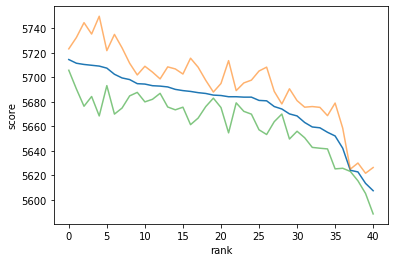

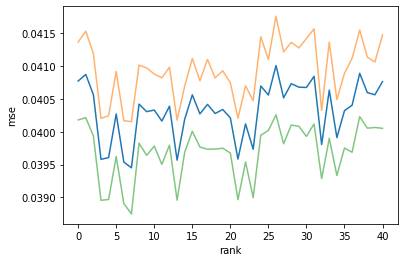

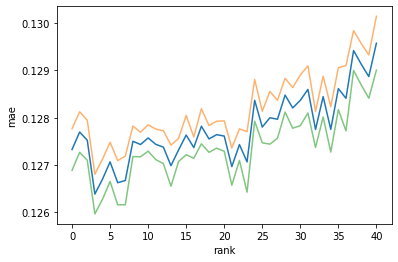

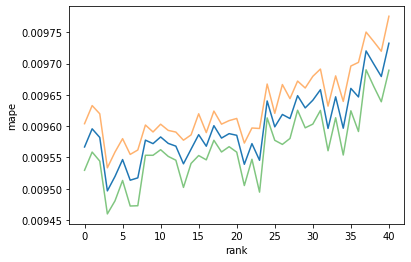

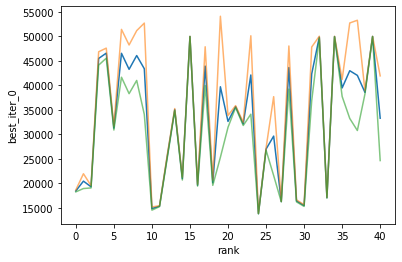

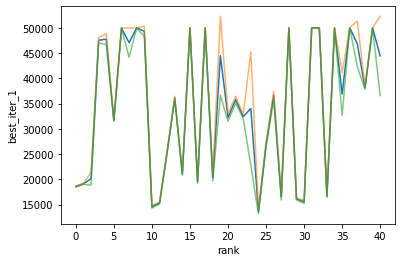

In [26]:
for m in metrics:
    sq = df_gsearch_results[m]
    sq_std = df_gsearch_results[m+'_std']
    plt.plot(sq)
    plt.plot(sq + sq_std, alpha=0.6)
    plt.plot(sq - sq_std, alpha=0.6)
    plt.xlabel('rank'); plt.ylabel(m); plt.show()

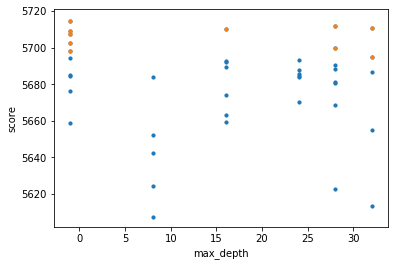

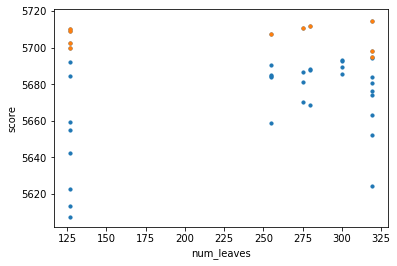

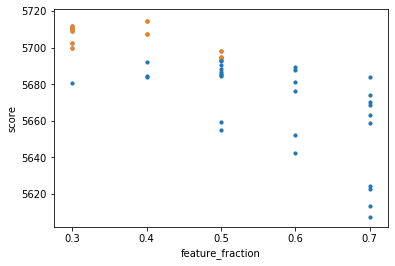

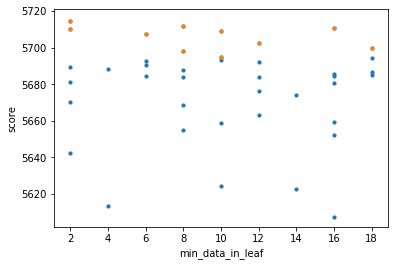

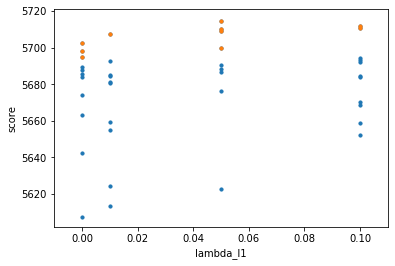

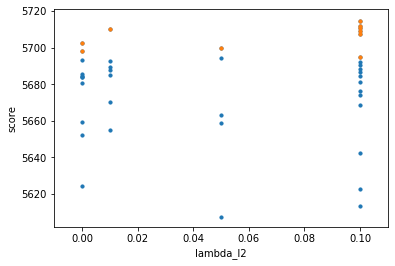

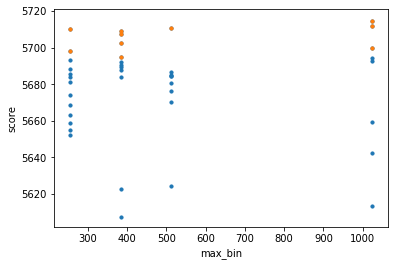

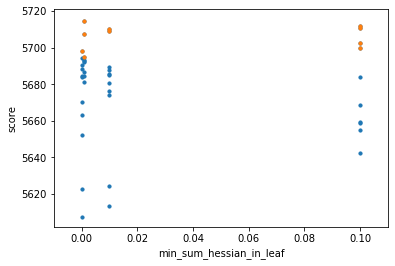

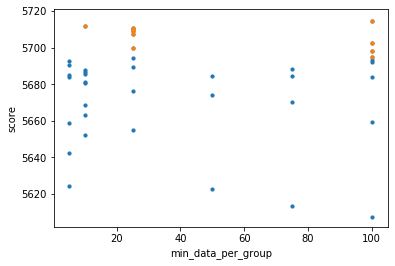

In [27]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=10)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['score'][:10], s=10)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

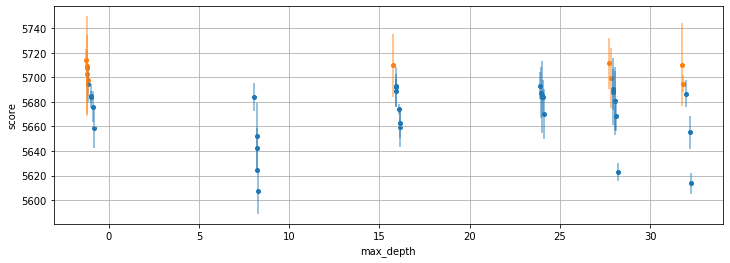

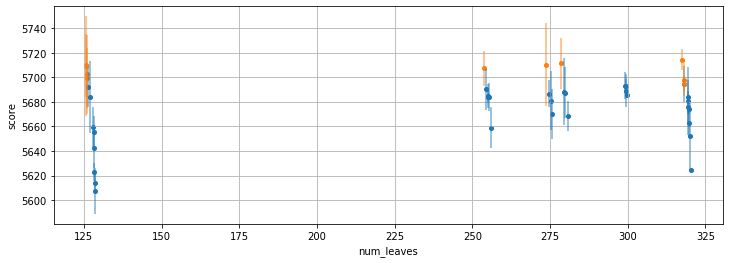

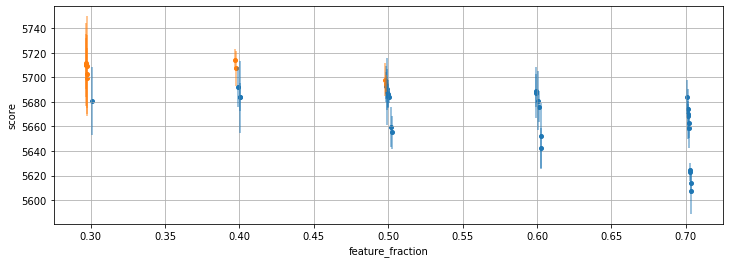

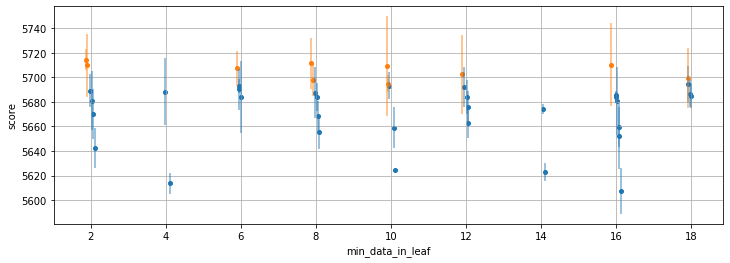

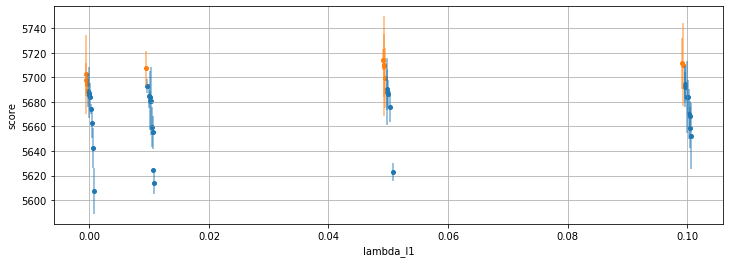

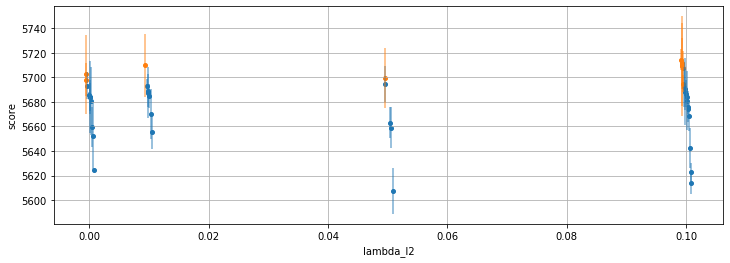

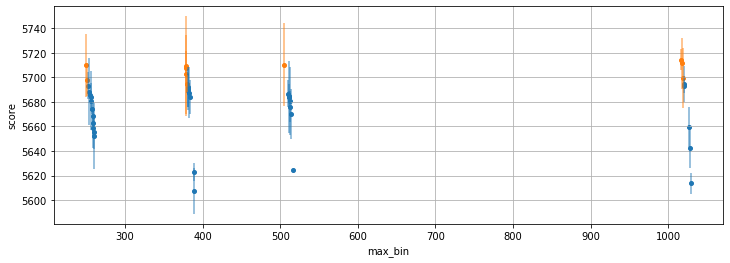

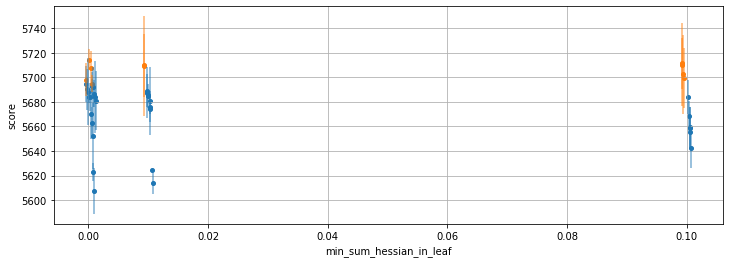

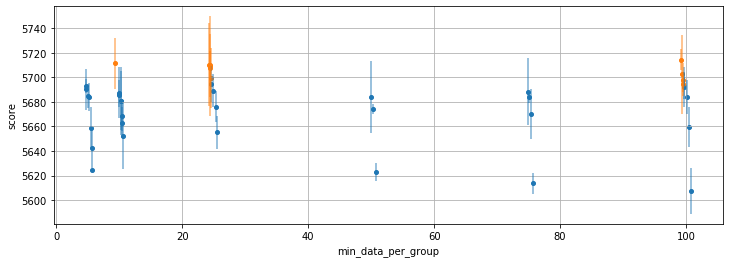

In [28]:
for p in params_gsearch.keys():
    plt.figure(figsize=(12, 4))
    x_sq = df_gsearch_results[p]
    x_shift = (x_sq.max() - x_sq.min())/3/len(x_sq)
    x_sq = x_sq + np.linspace(-x_shift, x_shift, len(x_sq), endpoint=True)
    plt.errorbar(x_sq[10:], df_gsearch_results['score'][10:], 
                 yerr=df_gsearch_results['score_std'][10:], linestyle="None", alpha=0.6)
    plt.errorbar(x_sq[:10], df_gsearch_results['score'][:10], 
                 yerr=df_gsearch_results['score_std'][:10], linestyle="None", alpha=0.6)
    plt.scatter(x_sq[10:], df_gsearch_results['score'][10:], s=16)
    plt.scatter(x_sq[:10], df_gsearch_results['score'][:10], s=16)
    plt.xlabel(p); plt.ylabel('score'); plt.grid(); plt.show()

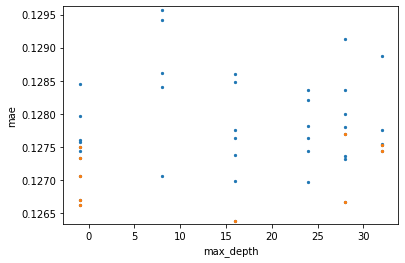

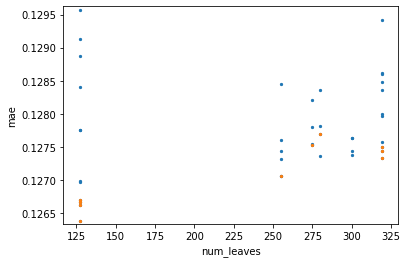

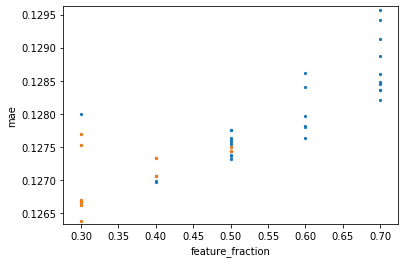

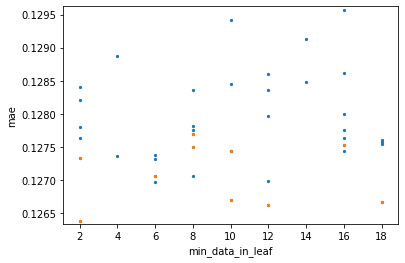

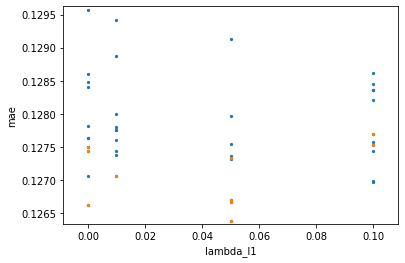

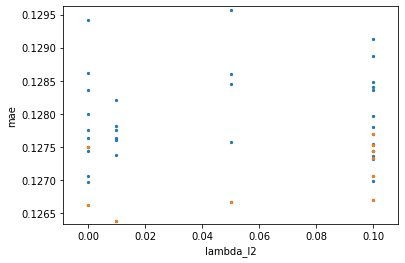

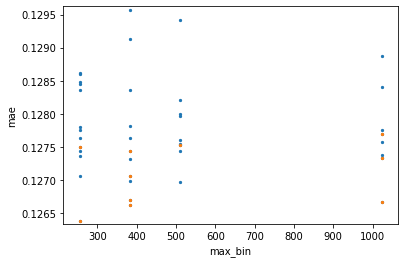

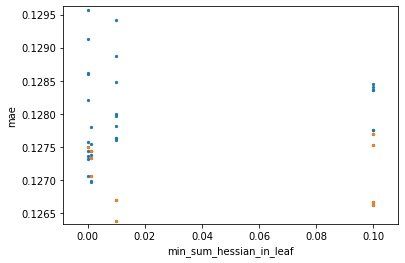

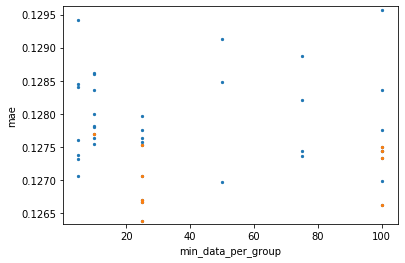

In [29]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=5)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=5)
    plt.ylim(df_gsearch_results['mae'].min()-0.00005, df_gsearch_results['mae'].max()+0.00005)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

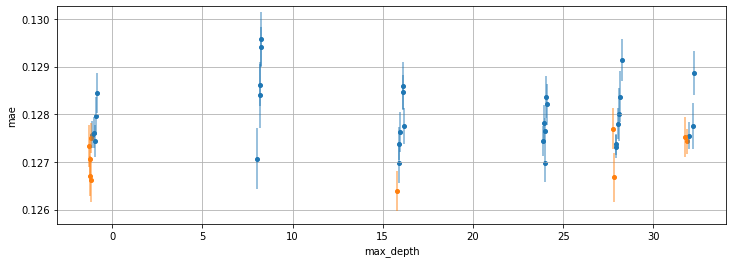

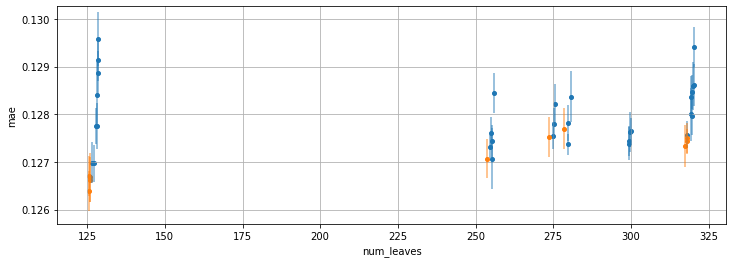

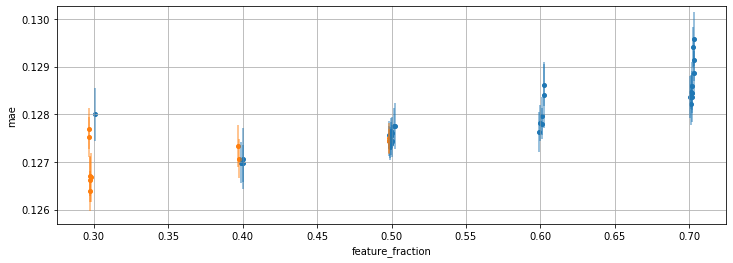

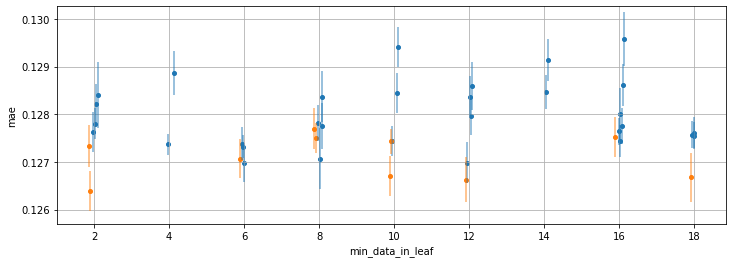

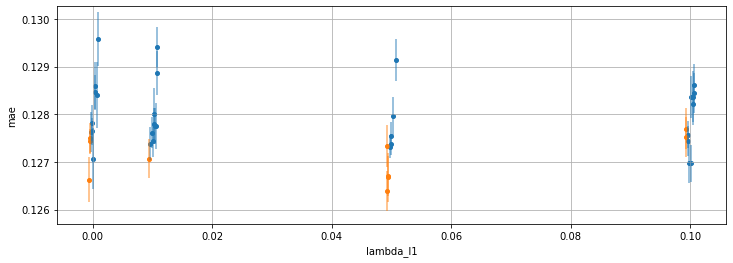

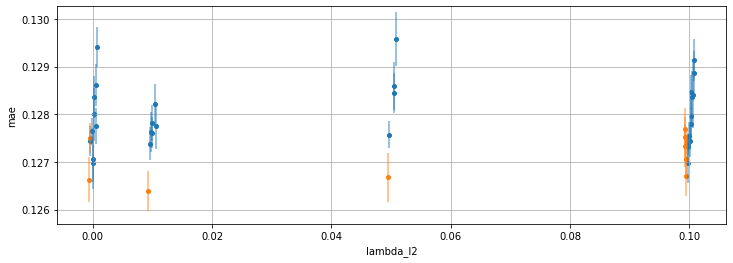

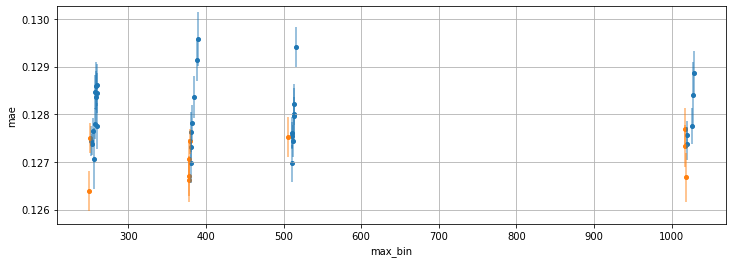

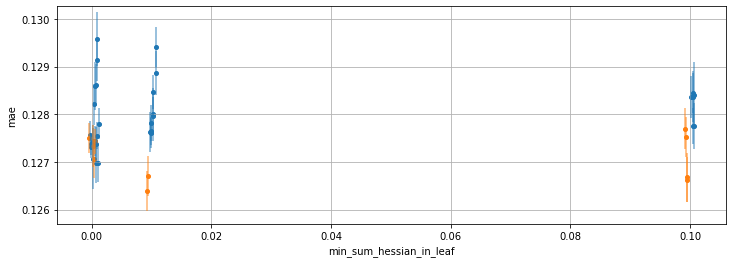

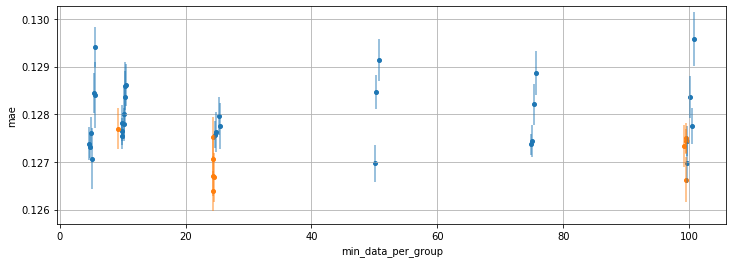

In [30]:
for p in params_gsearch.keys():
    plt.figure(figsize=(12, 4))
    x_sq = df_gsearch_results[p]
    x_shift = (x_sq.max() - x_sq.min())/3/len(x_sq)
    x_sq = x_sq + np.linspace(-x_shift, x_shift, len(x_sq), endpoint=True)
    plt.errorbar(x_sq[10:], df_gsearch_results['mae'][10:], 
                 yerr=df_gsearch_results['mae_std'][10:], linestyle="None", alpha=0.6)
    plt.errorbar(x_sq[:10], df_gsearch_results['mae'][:10], 
                 yerr=df_gsearch_results['mae_std'][:10], linestyle="None", alpha=0.6)
    plt.scatter(x_sq[10:], df_gsearch_results['mae'][10:], s=16)
    plt.scatter(x_sq[:10], df_gsearch_results['mae'][:10], s=16)
    plt.ylim(df_gsearch_results['mae'].min()-df_gsearch_results['mae_std'].max(), 
             df_gsearch_results['mae'].max()+df_gsearch_results['mae_std'].max())
    plt.xlabel(p); plt.ylabel('mae'); plt.grid(); plt.show()

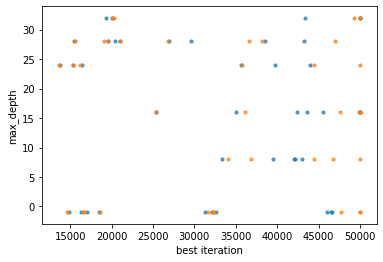

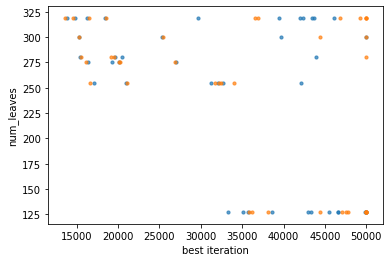

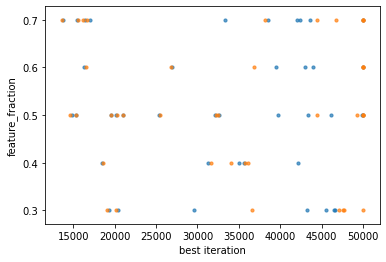

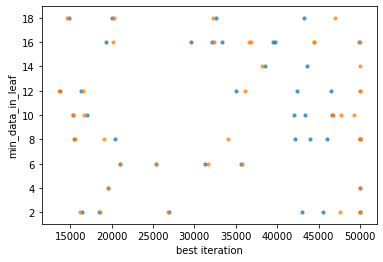

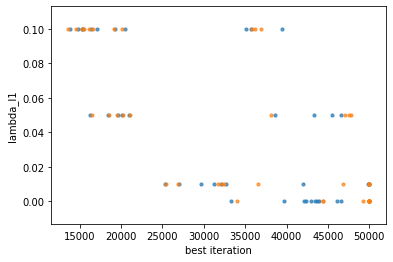

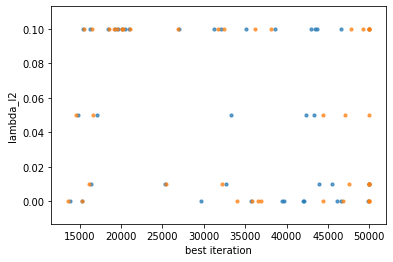

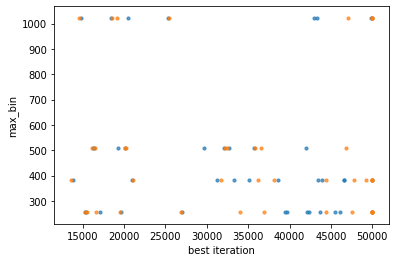

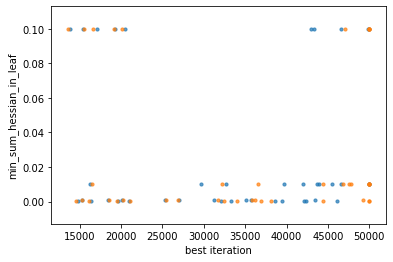

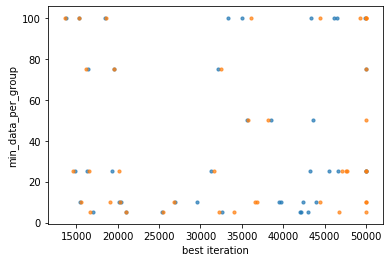

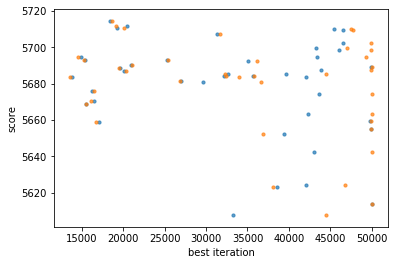

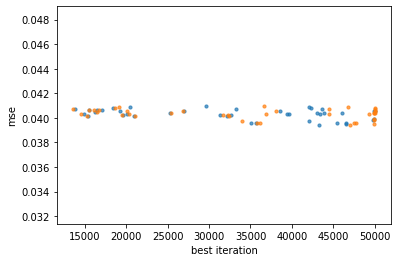

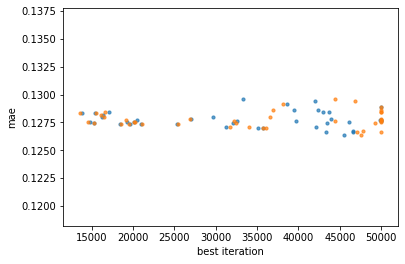

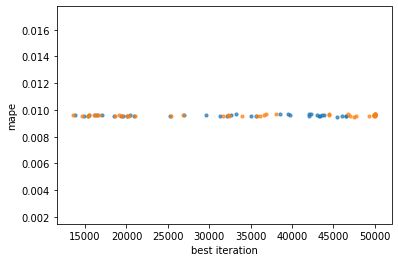

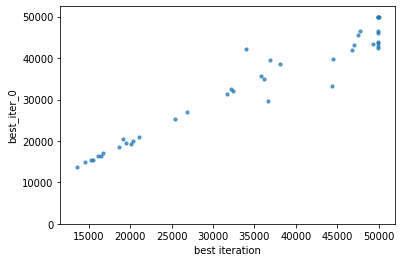

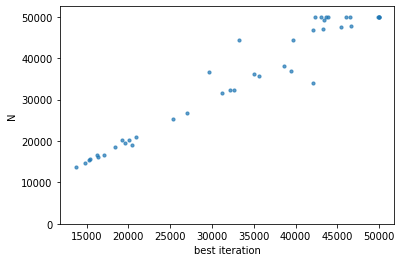

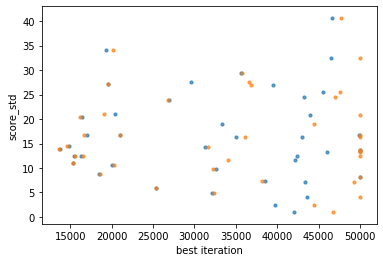

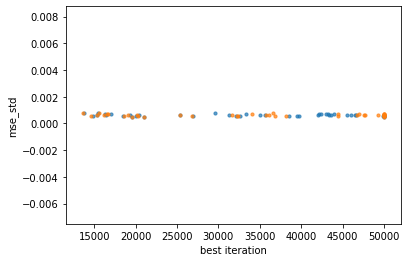

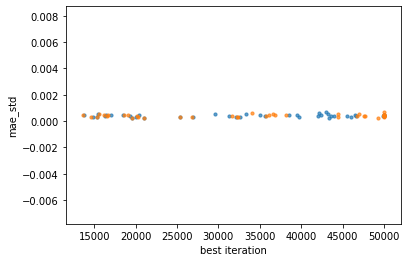

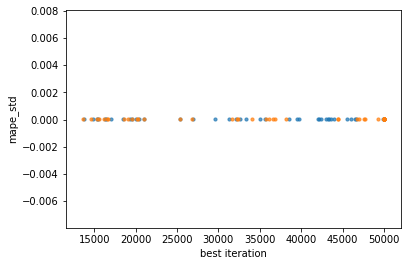

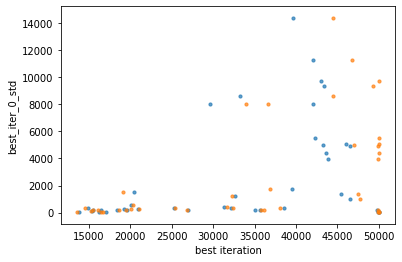

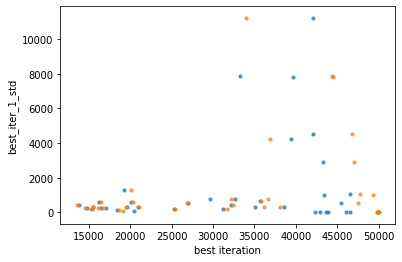

In [31]:
# best iteration
for c in df_gsearch_results.columns:
    for pg in price_groups:
        if c != 'best_iter_'+str(pg):
            plt.scatter(df_gsearch_results['best_iter_'+str(pg)], df_gsearch_results[c], s=10, 
                        label=str(pg), alpha=0.7)
            plt.ylabel(c)
        else:
            plt.hist(df_gsearch_results['best_iter_'+str(pg)], bins=30, label=str(pg), alpha=0.7)
            plt.ylabel('N')        
    plt.xlabel('best iteration')
    plt.show()

### Feature importance

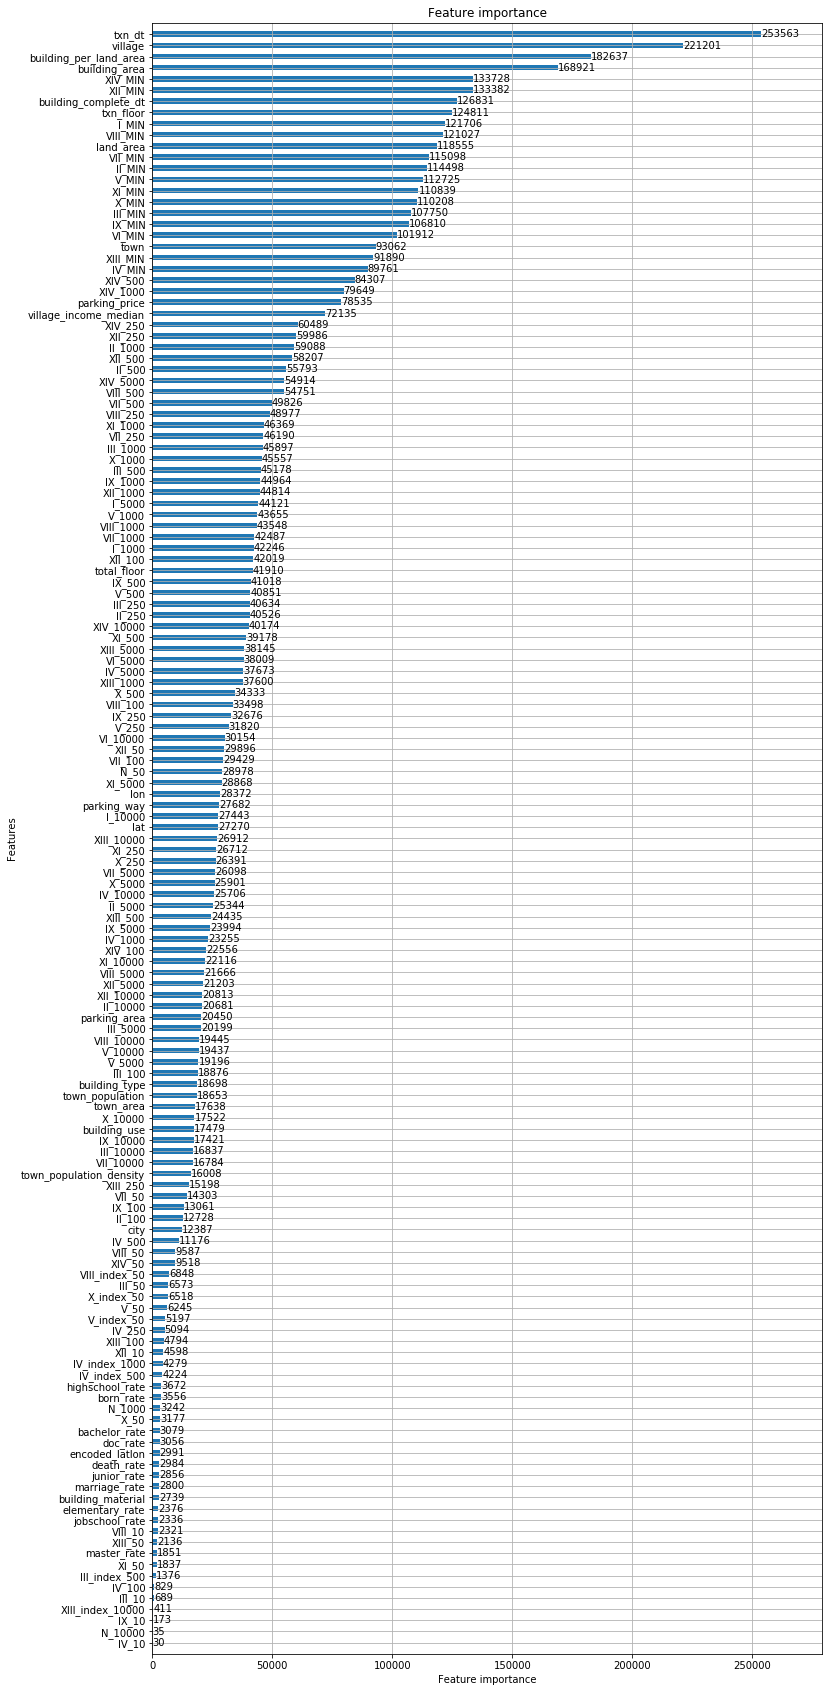

In [32]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

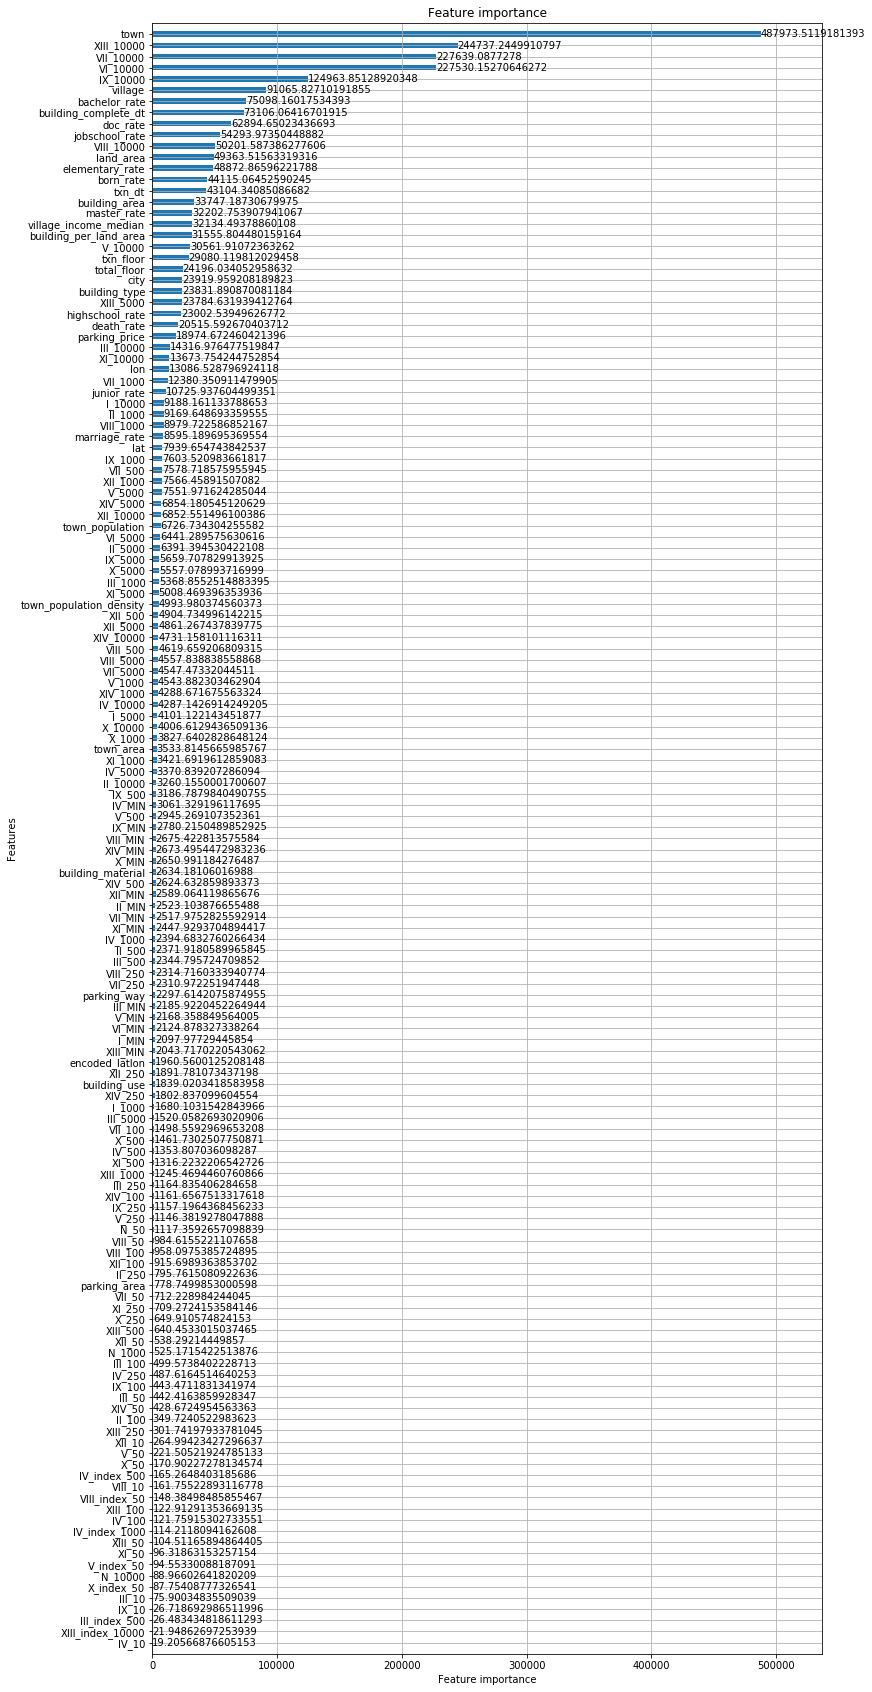

In [33]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()